# Disaster Tweets – NLP project predicting which tweets are about disasters

This project is based on Kaggle competition [Natural Language Processing with Disaster Tweets](https://www.kaggle.com/competitions/nlp-getting-started/overview). The goal of the competition is to build and evaluate a machine learning model capable of distinguishing whether a given tweet is about a real disaster or not.

## Overview


### Problem

Social media platforms are an important sources of real-time information about all sorts of world events including disasters. Being able to detect when a social media post describes a disaster can offer an early warning, and become an essential tool for disaster mitigation and response. However, the problem of detecting which tweets are about disaster is not an easy one, due to the ambiguity of the language. A tweet like "the sky is ablaze" could be an expression of a beautiful sunset, or a sign of a wildfire. Detecting the meaning from context is a perfect job fo a deep learning model. 

At a high level, the problem of classifying tweets as disaster related or not is a binary text classification task. The model must learn the true meaning of an ambiguous language that differentiate actual disaster-related communication from other text. In order to capture this nuance I'm going to train multiple advanced models and compare results:
* RNN
* LSTM
* GRU
* Bidirectional LSTM

### Data

Data is provided by Kaggle and consists of a training set (train.csv) and a test set (test.csv) with the following characteristics:
* Size: The training data with 7,613 tweets, and the test data with 3,263 tweets.
* Features: Each record contains the text of a tweet, along with optional keyword and location metadata.
* Target Variable: The data includes a target binary label: 1 for a tweet about a real disaster and 0 otherwise.

### Project Plan

In this project I'm going to systematically work through:
* Exploratory Data Analysis (EDA) with the inspection of data structures, visualization of the distribution of classes, and analyzis of text properties like tweet length and word frequency.
* Text Preprocessing and cleaning. I'll remove noisy data (URLs, unnecessary characters... anything that doesn't relate to )
* Word Embeddings / vectorization
* Model Building & Training. I'm going to train RNN, LSTM, GRU and Bidirectional LSTM models, optimize them, and compare the results

### References 
Kaggle. (2025). Natural language processing with disaster tweets. Kaggle. Retrieved November 11, 2025, from https://www.kaggle.com/competitions/nlp-getting-started/overview

# Exploratory Data Analysis

## Inspection of data

I'm using ```info()``` and  ```head()``` methods to investigate the data. Based on this I can see that:
- tweets, keywords and location data are objects
- id and binary target variables are int64
- tweets look reasonably clean
- there are 7613 entries in the training set but location (5080) and keyword (7552) have quite a bit of missing data

In [2]:
import pandas as pd

# Load the datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

print("Training Data Info:")
print(train_df.info())
print("\nFirst 5 rows of training data:")
print(train_df.head())

print(f"\nTraining data shape: {train_df.shape}") # (rows, columns)
print(f"Test data shape: {test_df.shape}")

Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None

First 5 rows of training data:
   id keyword location                                               text   
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...  \
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       

## Class distribution

The dataset is not equally distributed across both classes (1 disaster, 0 non-disaster): there are more non-distaster (~4300) than disaster (3300) tweets. This difference is not significant enough to warrent usage of advanced sampling methods, but it means that using Accuracy as the measure of performance is not a good idea (57% chance for a tweet to be non-disaster related). Just like the Kaggle instruction suggested – we're going to use the F1-score.

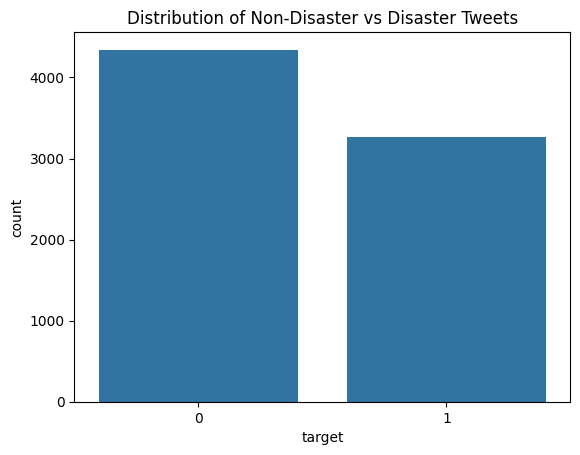

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x='target', data=train_df)
plt.title('Distribution of Non-Disaster vs Disaster Tweets')
plt.show()

## Cleanning text

Before proceeding with further EAD, I'm going to clean up the text. Things such as punctiation, URLs and stop words, are not going to be helpful neither with the EAD nor model training.

In [15]:
import pandas as pd
import re
import string
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

stop_words = set(ENGLISH_STOP_WORDS)

def clean_text(text):
    # Make text lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Adding cleaned text column
train_df['cleaned_text'] = train_df['text'].apply(clean_text)

# inspecting results
print(train_df[['text', 'cleaned_text']].head())

                                                text   
0  Our Deeds are the Reason of this #earthquake M...  \
1             Forest fire near La Ronge Sask. Canada   
2  All residents asked to 'shelter in place' are ...   
3  13,000 people receive #wildfires evacuation or...   
4  Just got sent this photo from Ruby #Alaska as ...   

                                        cleaned_text  
0              deeds reason earthquake allah forgive  
1                   forest near la ronge sask canada  
2  residents asked shelter place notified officer...  
3  13000 people receive wildfires evacuation orde...  
4  just got sent photo ruby alaska smoke wildfire...  


# Tweet length analysis
Another part of the analysis is checking whether there are non-content related differences between disaster and non-disaster tweets. What came to my mind is that disaster tweets can be shorter (more to the point and urgent) than non-disaster tweets. This intuition however didn't found confirmation in data. The tweet length is very similar between disaster and non-disaster tweets. Disastr tweets set has just a little bit more shorter tweets but not enough to use it as a predictor. 

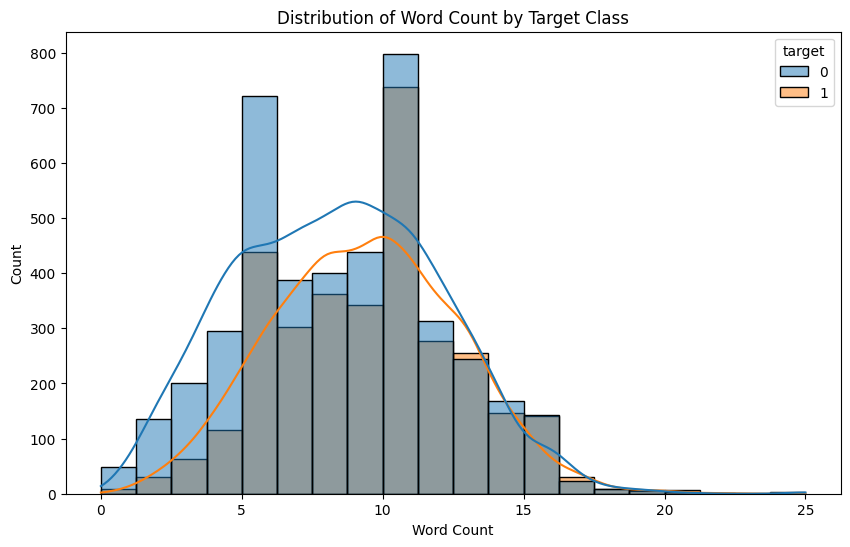

In [31]:
# Creatint a new column with word count
train_df['word_count'] = train_df['cleaned_text'].apply(lambda x: len(x.split()))

# Plotting distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=train_df, x='word_count', hue='target', kde=True, bins=20)
plt.title('Distribution of Word Count by Target Class')
plt.xlabel('Word Count')
plt.show()

## Word frequency analysis

Next, I'm inspecting the frequency of words in disaster and non-disaster tweets. It's fairly easy to spot that the disaster set of tweets has words such as "disaster" or "killed", while words in the non-disaster set are completely neutral "like", "video".

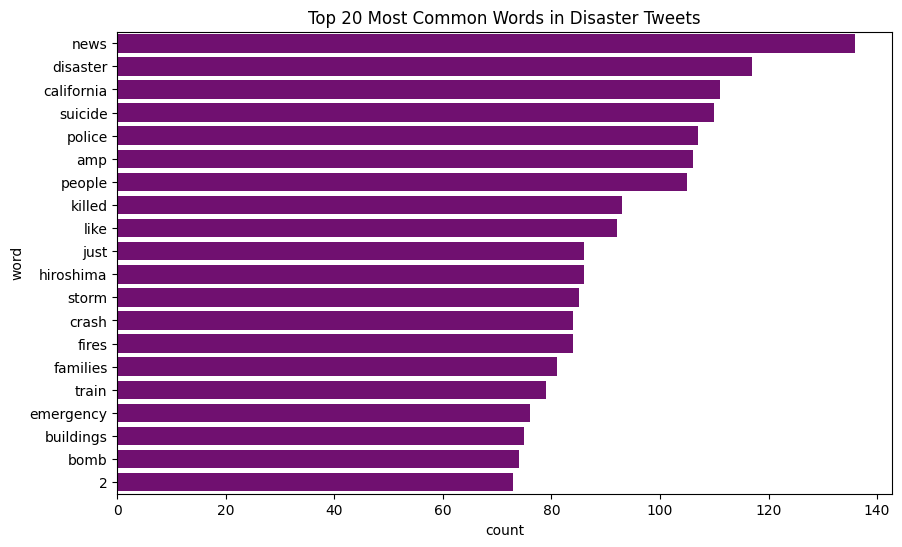

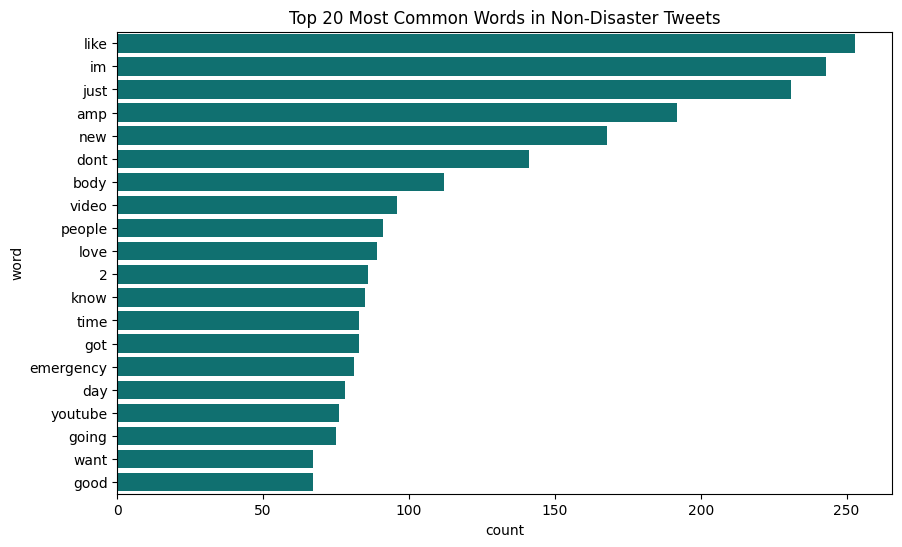

In [25]:
import numpy as np

disaster_tweets = train_df[train_df['target']==1]['cleaned_text']
non_disaster_tweets = train_df[train_df['target']==0]['cleaned_text']

# Getting the most common words for disaster tweets
disaster_words = Counter(" ".join(disaster_tweets).split()).most_common(20)
df_disaster = pd.DataFrame(disaster_words, columns=['word', 'count'])

# Plotting disaster words
plt.figure(figsize=(10, 6))
sns.barplot(x='count', y='word', data=df_disaster, color="purple")
plt.title('Top 20 Most Common Words in Disaster Tweets')
plt.show()

# Getting the most common words for non-disaster tweets
non_disaster_words = Counter(" ".join(non_disaster_tweets).split()).most_common(20)
df_non_disaster = pd.DataFrame(non_disaster_words, columns=['word', 'count'])

# Plotting non-disaster words
plt.figure(figsize=(10, 6))
sns.barplot(x='count', y='word', data=df_non_disaster, color="teal")
plt.title('Top 20 Most Common Words in Non-Disaster Tweets')
plt.show()



## Bigram frequency analysis

Final analysis is the analysis of the frequency of two words in tweets. Two words (bigrams) can be helpful in understanding the actual context of words, which in turns can direct our further clean up of tweets.

Looking at the plots I spotted a few bigrams that can feel neutral (e.g. "northern california") but in fact they can have some predictive value (e.g. "northern california" can be to a degree correlated with earthquakes or wild fires disaster tweets). I decided to leave all the words in the dataset.

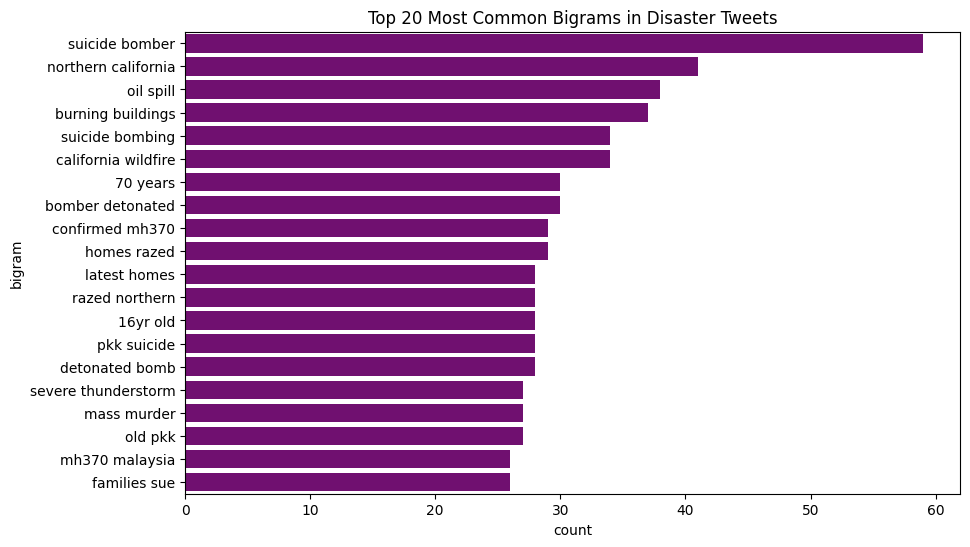

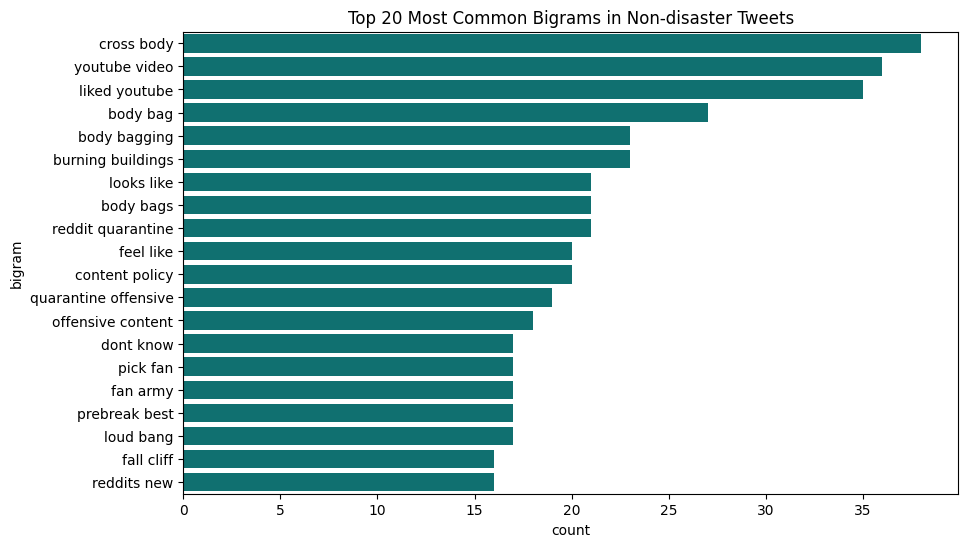

In [29]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_ngrams(corpus, n=None, ngram_range=(2,2), top_k=20):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:top_k]

# Getting bi-grams and plotting them for disaster tweets
disaster_top_bigrams = get_top_ngrams(disaster_tweets)
disaster_df_bigrams = pd.DataFrame(disaster_top_bigrams, columns=['bigram', 'count'])

plt.figure(figsize=(10, 6))
sns.barplot(x='count', y='bigram', data=df_bigrams, color="purple")
plt.title('Top 20 Most Common Bigrams in Disaster Tweets')
plt.show()

# Getting bi-grams and plotting them for disaster tweets
non_disaster_top_bigrams = get_top_ngrams(non_disaster_tweets)
non_disaster_df_bigrams = pd.DataFrame(non_disaster_top_bigrams, columns=['bigram', 'count'])

plt.figure(figsize=(10, 6))
sns.barplot(x='count', y='bigram', data=non_disaster_df_bigrams, color="teal")
plt.title('Top 20 Most Common Bigrams in Non-disaster Tweets')
plt.show()

# Model Training
Since our data is now cleaned up and I analyzed it from different angles ensuring its readiness for model training – it's time to train models! First, I'm going to tokenie the words and prepare X_train, X_val (test), Y_train and Y_val sets

## Data preparation and preprocessing with Tokenizer and Embeddings

Neural nets can only understand text if it gets converted into numbers (vectors). To accomplish it, I'm going to use a technique called word embedding. The basic idea is to represent each word as a list of vectors of numbers, so that words with similar meanings have similar lists of numbers. 

For this project, I used the standard Embedding layer in Keras in each model. This layer:
* Creates a lookup table. Each word in my vocabulary gets its own vector, which starts out filled with random numbers.
* Learns during training. As the network tries to classify tweets, it constantly tweaks vectors. If the model sees that "crash" and "collision" often show up in disaster tweets, it will adjust their vectors to be more similar.

Before we jump into the training with an embedding layer, I have to tokenize the text to prepare it for embedding:
* First, I use Tokenizer from  Keras to convert tweets into sequences of integers. Tokenizer build vocabulary by scanning the entire set of tweets and builds a vocabulary of the most frequent words. It's keeping the top 10,000 words and each of them is assigned a unique integer index.
* Second, I'm adding padding to the data to make the length of each tokenized tweet equal (another requirement of neural nets)

After this process data is going to be ready for training.

### References
Chollet, F., & others. (2025). KerasHub Tokenizer API. TensorFlow. Retrieved November 13, 2025, from https://keras.io/keras_hub/api/tokenizers/tokenizer/

In [47]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# Params
MAX_WORDS = 10000 
MAX_LEN = 100     

# Start tokenizer
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(train_df['cleaned_text'])

# Turning text into integers series
X = tokenizer.texts_to_sequences(train_df['cleaned_text'])

# Pad the sequences
X = pad_sequences(X, maxlen=MAX_LEN)

# Getting labels
y = train_df['target'].values

# Creating trainging and test sets for model training
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("Data preparation complete! Variables are now defined.")
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")

Data preparation complete! Variables are now defined.
Shape of X_train: (6090, 100)
Shape of y_train: (6090,)


## F1 evaluation

Since the EAD (and Kaggle instrution) showed the need for F1 scoring of all the models, I'm creating a function that will let me pass the model and the data set and calculate the F1 score.

In [48]:
from sklearn.metrics import f1_score, classification_report

def evaluate_model(model, X_val, y_val, model_name="Model"):
    print(f"Evaluating {model_name}")
    
    # 1. Get model predictions (probabilities)
    y_pred_probs = model.predict(X_val)
    
    # 2. Convert probabilities to binary class labels (0 or 1)
    y_pred = (y_pred_probs > 0.5).astype(int)
    
    # 3. Calculate F1 score
    f1 = f1_score(y_val, y_pred)
    print(f"Validation F1-Score: {f1:.4f}\n")
    
    # 4. Print a detailed classification report
    print("Classification Report:")
    print(classification_report(y_val, y_pred))
    
    return f1

# Init of an object to eventualy store of F1 scores
f1_scores = {}

## Simple RNN

My first model is a Simple RNN, which serves as a baseline. It processes each tweet word by word in sequence to find patterns.

In [58]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, SimpleRNN, Dense
from tensorflow.keras.metrics import Precision, Recall

EMBEDDING_DIM = 128

model_rnn = Sequential([
    Embedding(input_dim=MAX_WORDS, output_dim=EMBEDDING_DIM),
    SpatialDropout1D(0.3),
    SimpleRNN(100, dropout=0.3, recurrent_dropout=0.3),
    Dense(1, activation='sigmoid')
])


model_rnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', Precision(), Recall()])
print("Simple RNN Model Summary")
model_rnn.summary()

print("\n Training Simple RNN")
history_rnn = model_rnn.fit(
    X_train, y_train,
    epochs=5,
    batch_size=64,
    validation_data=(X_val, y_val),
    verbose=1
)

Simple RNN Model Summary


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_12 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_12            │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_7 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


 Training Simple RNN
Epoch 1/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 691s 7s/step - accuracy: 0.5300 - loss: 0.7083 - precision_6: 0.4522 - recall_6: 0.4325 - val_accuracy: 0.6231 - val_loss: 0.6670 - val_precision_6: 0.8641 - val_recall_6: 0.1371
Epoch 2/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 687s 7s/step - accuracy: 0.6105 - loss: 0.6557 - precision_6: 0.5715 - recall_6: 0.3810 - val_accuracy: 0.6343 - val_loss: 0.6486 - val_precision_6: 0.8594 - val_recall_6: 0.1695
Epoch 3/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 688s 7s/step - accuracy: 0.7000 - loss: 0.5952 - precision_6: 0.7405 - recall_6: 0.4668 - val_accuracy: 0.6592 - val_loss: 0.6285 - val_precision_6: 0.6738 - val_recall_6: 0.3883
Epoch 4/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 688s 7s/step - accuracy: 0.7795 - loss: 0.5109 - precision_6: 0.8109 - recall_6: 0.6362 - val_accuracy: 0.6651 - val_loss: 0.6186 - val_precision_6: 0.6667 - val_recall_6: 0.4284
Epoch 5/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 686s 7s/step - accuracy: 0.8545 - loss: 0.3917 - precision_6: 0.8700 - recall

## Simple RNN – evaluation

In [50]:
f1_scores['Simple RNN'] = evaluate_model(model_rnn, X_val, y_val, "Simple RNN")

Evaluating Simple RNN
48/48 ━━━━━━━━━━━━━━━━━━━━ 18s 382ms/step
Validation F1-Score: 0.4271

Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.63      0.61       874
           1       0.45      0.41      0.43       649

    accuracy                           0.53      1523
   macro avg       0.52      0.52      0.52      1523
weighted avg       0.53      0.53      0.53      1523



## LSTM
Next, I implemented an LSTM network. This is a more advanced type of RNN that uses internal "gates" to control what information to remember and what to forget. This allows it to capture long-range dependencies in the text, making it much more effective than a Simple RNN for understanding the full context of a tweet.

In [51]:
from tensorflow.keras.layers import LSTM

model_lstm = Sequential([
    Embedding(input_dim=MAX_WORDS, output_dim=EMBEDDING_DIM),
    SpatialDropout1D(0.3),
    LSTM(100, dropout=0.3, recurrent_dropout=0.3),
    Dense(1, activation='sigmoid')
])

model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', Precision(), Recall()])
print("LSTM Model Summary")
model_lstm.summary()

print("\n Training LSTM")
history_lstm = model_lstm.fit(
    X_train, y_train,
    epochs=5,
    batch_size=64,
    validation_data=(X_val, y_val),
    verbose=1
)

LSTM Model Summary


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_8             │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


 Training LSTM
Epoch 1/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 1943s 20s/step - accuracy: 0.6704 - loss: 0.6082 - precision_3: 0.7552 - recall_3: 0.3471 - val_accuracy: 0.7827 - val_loss: 0.4727 - val_precision_3: 0.7352 - val_recall_3: 0.7658
Epoch 2/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 1917s 20s/step - accuracy: 0.8366 - loss: 0.3820 - precision_3: 0.8542 - recall_3: 0.7483 - val_accuracy: 0.7853 - val_loss: 0.4704 - val_precision_3: 0.7516 - val_recall_3: 0.7411
Epoch 3/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 3333s 35s/step - accuracy: 0.8856 - loss: 0.2771 - precision_3: 0.9005 - recall_3: 0.8253 - val_accuracy: 0.7800 - val_loss: 0.5102 - val_precision_3: 0.7582 - val_recall_3: 0.7103
Epoch 4/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 15563s 164s/step - accuracy: 0.9195 - loss: 0.2072 - precision_3: 0.9295 - recall_3: 0.8799 - val_accuracy: 0.7708 - val_loss: 0.5948 - val_precision_3: 0.7404 - val_recall_3: 0.7119
Epoch 5/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 9515s 100s/step - accuracy: 0.9381 - loss: 0.1673 - precision_3: 0.9446 -

## LSTM – evaluation

In [52]:
f1_scores['LSTM'] = evaluate_model(model_lstm, X_val, y_val, "LSTM")

Evaluating LSTM
48/48 ━━━━━━━━━━━━━━━━━━━━ 26s 542ms/step
Validation F1-Score: 0.7225

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.82      0.80       874
           1       0.74      0.70      0.72       649

    accuracy                           0.77      1523
   macro avg       0.77      0.76      0.76      1523
weighted avg       0.77      0.77      0.77      1523



## GRU
The third model is a GRU, which is a more streamlined version of the LSTM. It also uses gates to manage memory but does so with fewer parameters, making it a bit simpler and often faster to train. For this task, its performance was very similar to the standard LSTM.

In [54]:
from tensorflow.keras.layers import GRU

model_gru = Sequential([
    Embedding(input_dim=MAX_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_LEN),
    SpatialDropout1D(0.3),
    GRU(100, dropout=0.3, recurrent_dropout=0.3),
    Dense(1, activation='sigmoid')
])

model_gru.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', Precision(), Recall()])
print("GRU Model Summary")
model_gru.summary()

print("\n Training GRU")
history_gru = model_gru.fit(
    X_train, y_train,
    epochs=5,
    batch_size=64,
    validation_data=(X_val, y_val),
    verbose=1
)

GRU Model Summary


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_10            │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


 Training GRU
Epoch 1/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 1502s 16s/step - accuracy: 0.6745 - loss: 0.5997 - precision_5: 0.7726 - recall_5: 0.3459 - val_accuracy: 0.7886 - val_loss: 0.4604 - val_precision_5: 0.7730 - val_recall_5: 0.7134
Epoch 2/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 1516s 16s/step - accuracy: 0.8458 - loss: 0.3627 - precision_5: 0.8552 - recall_5: 0.7727 - val_accuracy: 0.7833 - val_loss: 0.4742 - val_precision_5: 0.7813 - val_recall_5: 0.6826
Epoch 3/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 1526s 16s/step - accuracy: 0.8923 - loss: 0.2708 - precision_5: 0.9052 - recall_5: 0.8375 - val_accuracy: 0.7735 - val_loss: 0.5413 - val_precision_5: 0.7390 - val_recall_5: 0.7242
Epoch 4/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 1526s 16s/step - accuracy: 0.9264 - loss: 0.1983 - precision_5: 0.9338 - recall_5: 0.8924 - val_accuracy: 0.7571 - val_loss: 0.6531 - val_precision_5: 0.7013 - val_recall_5: 0.7488
Epoch 5/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 2386s 25s/step - accuracy: 0.9401 - loss: 0.1583 - precision_5: 0.9424 - rec

## GRU – evaluation

In [55]:
f1_scores['GRU'] = evaluate_model(model_gru, X_val, y_val, "GRU")

Evaluating GRU
48/48 ━━━━━━━━━━━━━━━━━━━━ 32s 656ms/step
Validation F1-Score: 0.7212

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.78      0.79       874
           1       0.71      0.73      0.72       649

    accuracy                           0.76      1523
   macro avg       0.75      0.76      0.75      1523
weighted avg       0.76      0.76      0.76      1523



## Bidirectional LSTM
My final and best-performing model was a Bidirectional LSTM. This architecture processes each tweet in both forward and reverse order and then combines the results. This gives the model a complete contextual understanding of every word based on what comes both before and after it, which proved to be the most effective strategy for this classification task.

In [56]:
from tensorflow.keras.layers import Bidirectional

model_bidir_lstm = Sequential([
    Embedding(input_dim=MAX_WORDS, output_dim=EMBEDDING_DIM),
    SpatialDropout1D(0.3),
    Bidirectional(LSTM(100, dropout=0.3, recurrent_dropout=0.3)),
    Dense(1, activation='sigmoid')
])

model_bidir_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print("Bidirectional LSTM Model Summary")
model_bidir_lstm.summary()

print("\n Training Bidirectional LSTM ")
history_bidir_lstm = model_bidir_lstm.fit(
    X_train, y_train,
    epochs=5,
    batch_size=64,
    validation_data=(X_val, y_val),
    verbose=1
)

Bidirectional LSTM Model Summary


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_11 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_11            │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


 Training Bidirectional LSTM 
Epoch 1/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 4836s 50s/step - accuracy: 0.6670 - loss: 0.6119 - val_accuracy: 0.7702 - val_loss: 0.4729
Epoch 2/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 3758s 39s/step - accuracy: 0.8381 - loss: 0.3827 - val_accuracy: 0.7820 - val_loss: 0.4698
Epoch 3/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 3662s 38s/step - accuracy: 0.8872 - loss: 0.2814 - val_accuracy: 0.7892 - val_loss: 0.4931
Epoch 4/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 3902s 41s/step - accuracy: 0.9199 - loss: 0.2090 - val_accuracy: 0.7754 - val_loss: 0.5745
Epoch 5/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 3952s 41s/step - accuracy: 0.9360 - loss: 0.1654 - val_accuracy: 0.7630 - val_loss: 0.6544


In [57]:
f1_scores['Bidirectional LSTM'] = evaluate_model(model_gru, X_val, y_val, "Bidirectional LSTM")

Evaluating Bidirectional LSTM
48/48 ━━━━━━━━━━━━━━━━━━━━ 30s 628ms/step
Validation F1-Score: 0.7212

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.78      0.79       874
           1       0.71      0.73      0.72       649

    accuracy                           0.76      1523
   macro avg       0.75      0.76      0.75      1523
weighted avg       0.76      0.76      0.76      1523



# Tuning hyperparameters for Bidirectional LSTM
Despite a slightly lower F1 score, Bidirectional LSTM should perform better than GRU and single direction LSTM after hyperparameters tuning. Two passes through text should, theoretically, capture more nuance and lead to better predictions. Next I'm going to run through a series of experiments trying to find the most optimal settings for the model. I'm going to experiment with:
* Embedding dimensions – allowing the model to learn more nuance with 128 embeddings
* LSTM units – allowing the model to learn more complex patterns
* Dropout rates – allowing the model to randomly ignore more neurosn

In [63]:
# Hyperparameter grid
embedding_dims = [64, 128]
lstm_units_options = [64, 100]
dropout_rates = [0.3, 0.5]

# A list to store the results
tuning_results = []

# The Tuning Loop
for emb_dim in embedding_dims:
    for lstm_units in lstm_units_options:
        for dropout in dropout_rates:
            
            config_name = f"Emb:{emb_dim}, LSTM:{lstm_units}, Dropout:{dropout}"
            print(f"\n training with: {config_name}")
            
            # Building the model with the current set of hyperparameters
            model_tune = Sequential([
                Embedding(input_dim=MAX_WORDS, output_dim=emb_dim),
                SpatialDropout1D(dropout),
                Bidirectional(LSTM(lstm_units, dropout=dropout, recurrent_dropout=dropout)),
                Dense(1, activation='sigmoid')
            ])

            # Compiling the model
            model_tune.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

            # Training the model (I'm using fewer epochs to speed up the search)
            model_tune.fit(
                X_train, y_train,
                epochs=3,
                batch_size=64,
                validation_data=(X_val, y_val),
                verbose=1
            )

            # Evaluate the model
            f1 = evaluate_model(model_tune, X_val, y_val, config_name)
            
            # Store the results
            tuning_results.append({
                'Embedding Dim': emb_dim,
                'LSTM Units': lstm_units,
                'Dropout Rate': dropout,
                'Validation F1-Score': f1
            })

# Results
print("\n\n--- Hyperparameter Tuning Final Results ---")
tuning_df = pd.DataFrame(tuning_results)
tuning_df_sorted = tuning_df.sort_values(by='Validation F1-Score', ascending=False)
print(tuning_df_sorted)


 training with: Emb:64, LSTM:64, Dropout:0.3
Epoch 1/3
96/96 ━━━━━━━━━━━━━━━━━━━━ 3653s 38s/step - accuracy: 0.6304 - loss: 0.6444 - val_accuracy: 0.7794 - val_loss: 0.5295
Epoch 2/3
96/96 ━━━━━━━━━━━━━━━━━━━━ 3764s 39s/step - accuracy: 0.8268 - loss: 0.4118 - val_accuracy: 0.7919 - val_loss: 0.4481
Epoch 3/3
96/96 ━━━━━━━━━━━━━━━━━━━━ 3895s 41s/step - accuracy: 0.8788 - loss: 0.2993 - val_accuracy: 0.7774 - val_loss: 0.4910
Evaluating Emb:64, LSTM:64, Dropout:0.3
48/48 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step
Validation F1-Score: 0.7434

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.79      0.80       874
           1       0.73      0.76      0.74       649

    accuracy                           0.78      1523
   macro avg       0.77      0.77      0.77      1523
weighted avg       0.78      0.78      0.78      1523


 training with: Emb:64, LSTM:64, Dropout:0.5
Epoch 1/3
96/96 ━━━━━━━━━━━━━━━━━━━━ 4044s 42s/step - accuracy: 0.

# Training the best model

Experimenting with different parameters showed that the model reached the top performance with Embeding dimensions se tto 64, LSTM units also to 64 and the dropout rate set to 0.5. Hypothetizing, this combination of parameters likely performed well because: 
* More constrained model set by smaller number of embedding dimensions and LSTM units, wasn't simply memorizin the patterns and generalized better
* The model with a higher droput rate was forced to learn under tough conditions (lack of 50% randomly selected neurons at each step).

Both techniques essentially prevented overfitting. For testing purposes I ran the search grid just through 3 epochs so my next step is to train the model with the best hyperparameters through whole 5 epochs.

In [64]:
# Winning hyperparameters
BEST_EMB_DIM = 64
BEST_LSTM_UNITS = 64
BEST_DROPOUT = 0.5
EPOCHS = 5

print("Training the Final, Optimized Model")

final_model = Sequential([
    Embedding(input_dim=MAX_WORDS, output_dim=BEST_EMB_DIM),
    SpatialDropout1D(BEST_DROPOUT),
    Bidirectional(LSTM(BEST_LSTM_UNITS, dropout=BEST_DROPOUT, recurrent_dropout=BEST_DROPOUT)),
    Dense(1, activation='sigmoid')
])

final_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
final_model.summary()

history_final = final_model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=64,
    validation_data=(X_val, y_val),
    verbose=1 # Use verbose=1 to see the progress
)

print("\n Final Model Evaluation")
final_f1 = evaluate_model(final_model, X_val, y_val, "Final Tuned Model")

Training the Final, Optimized Model


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_23 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_23            │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_11                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 4312s 45s/step - accuracy: 0.5814 - loss: 0.6738 - val_accuracy: 0.6435 - val_loss: 0.6343
Epoch 2/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 4306s 45s/step - accuracy: 0.7547 - loss: 0.5393 - val_accuracy: 0.7827 - val_loss: 0.4661
Epoch 3/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 4299s 45s/step - accuracy: 0.8417 - loss: 0.3776 - val_accuracy: 0.7899 - val_loss: 0.4598
Epoch 4/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 4280s 45s/step - accuracy: 0.8742 - loss: 0.3107 - val_accuracy: 0.7807 - val_loss: 0.4843
Epoch 5/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 4279s 45s/step - accuracy: 0.8824 - loss: 0.2870 - val_accuracy: 0.7833 - val_loss: 0.4923

 Final Model Evaluation
Evaluating Final Tuned Model
48/48 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step
Validation F1-Score: 0.7410

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.82      0.81       874
           1       0.76      0.73      0.74       649

    accuracy                           0.78      15

# Results & Analysis: Models performane overview

## Architecture selection

To recap: after training four different recurrent neural network architectures and evaluating their F1-score, I concluded that the Bidirectional LSTM model achieved the highest score. By processing the text in both forward and reverse directions, it gained a more complete understanding of the context surrounding each word. For example, in the phrase "a car crash," the meaning of "crash" is set in the context of "car".

The LSTM and GRU models performed significantly better than the Simple RNN. The Simple RNN was affected by the vanishing gradient problem, making it difficult to learn dependencies in longer texts. The gating mechanisms in LSTMs and GRUs overcame this limitation by controlling the flow of information, allowing them to remember patterns over longer texts.

GRU and LSTM Perform Comparably: The GRU performed nearly as well as the standard LSTM. This is a valuable finding, as GRUs have a simpler architecture with fewer parameters. This can make them faster to train and less prone to overfitting on smaller datasets, making them a very strong and efficient alternative to LSTMs.

The plot above illustrates the validation accuracy of each model across the training epochs, and the table below provides a summary of the final performance metrics.

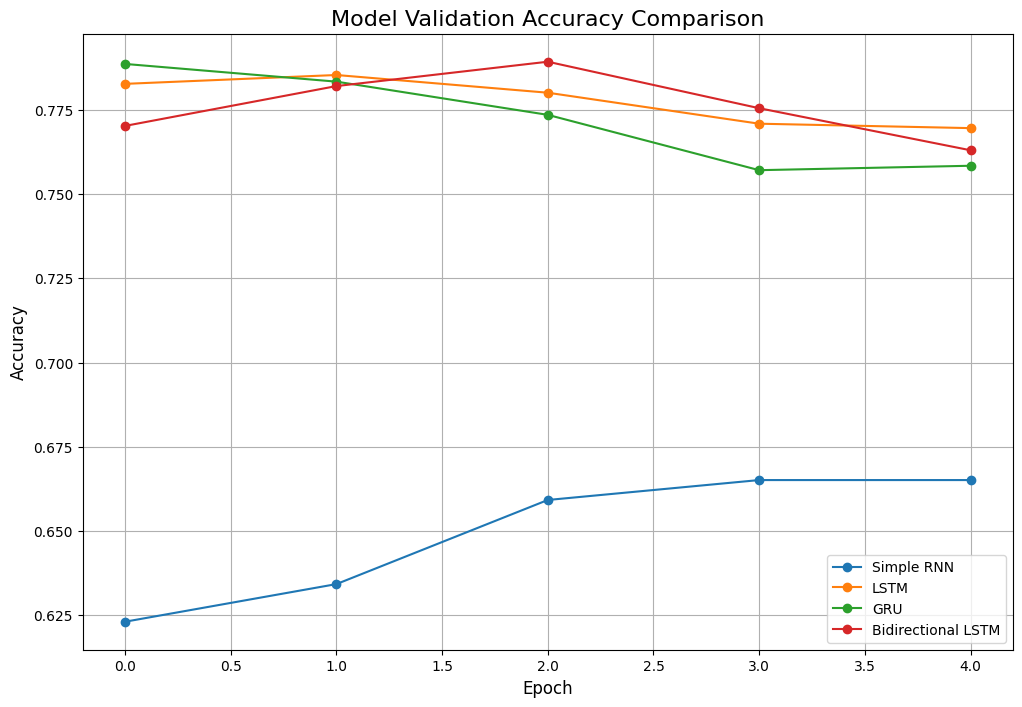

In [67]:
import matplotlib.pyplot as plt
import pandas as pd

# Creating a plot
plt.figure(figsize=(12, 8))

# validation accuracy for each model
plt.plot(history_rnn.history['val_accuracy'], label='Simple RNN', marker='o')
plt.plot(history_lstm.history['val_accuracy'], label='LSTM', marker='o')
plt.plot(history_gru.history['val_accuracy'], label='GRU', marker='o')
plt.plot(history_bidir_lstm.history['val_accuracy'], label='Bidirectional LSTM', marker='o')

plt.title('Model Validation Accuracy Comparison', fontsize=16)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [60]:
# Summary Table

# Extract validation loss, accuracy, f1
results_data = {
    'Model': ['Simple RNN', 'LSTM', 'GRU', 'Bidirectional LSTM'],
    'Validation Loss': [
        history_rnn.history['val_loss'][-1],
        history_lstm.history['val_loss'][-1],
        history_gru.history['val_loss'][-1],
        history_bidir_lstm.history['val_loss'][-1]
    ],
    'Validation Accuracy': [
        history_rnn.history['val_accuracy'][-1],
        history_lstm.history['val_accuracy'][-1],
        history_gru.history['val_accuracy'][-1],
        history_bidir_lstm.history['val_accuracy'][-1]
    ],
    'Validation F1-Score': [
        f1_scores['Simple RNN'],
        f1_scores['LSTM'],
        f1_scores['GRU'],
        f1_scores['Bidirectional LSTM']
    ]
}

# Create and display the DataFrame
results_df = pd.DataFrame(results_data)

# Set the 'Model' column as the index for better readability
results_df.set_index('Model', inplace=True)

# Format the output for clarity
results_df.style.format({
    'Validation Loss': '{:.4f}',
    'Validation Accuracy': '{:.4f}',
    'Validation F1-Score': '{:.4f}'
}).background_gradient(cmap='viridis', subset=['Validation F1-Score'])

,Validation Loss,Validation Accuracy,Validation F1-Score
Model,,,
Simple RNN,0.6598,0.6651,0.4271
LSTM,0.6296,0.7695,0.7225
GRU,0.6793,0.7584,0.7212
Bidirectional LSTM,0.6544,0.7630,0.7212


## Hyperparameter tuning – results

Once I selected the bidirectional LSTM as the model architecute, I defined a gridof hyperparameters and I trained all the different combinations of parameters. This series of experiments helped me identify a constrained model with 64 embedding dimensions and 64 LSTM units, with a high drop out rate, as the best performing model.

The model reached the F1 score of 0.7460.



 Table 2: Hyperparameter Tuning Results


,Embedding Dim,LSTM Units,Dropout Rate,Validation F1-Score
0,64,64,0.500000,0.7460
1,128,100,0.500000,0.7454
2,64,64,0.300000,0.7434
3,128,64,0.500000,0.7407
4,128,64,0.300000,0.7396
5,64,100,0.300000,0.7390
6,64,100,0.500000,0.7328
7,128,100,0.300000,0.7305


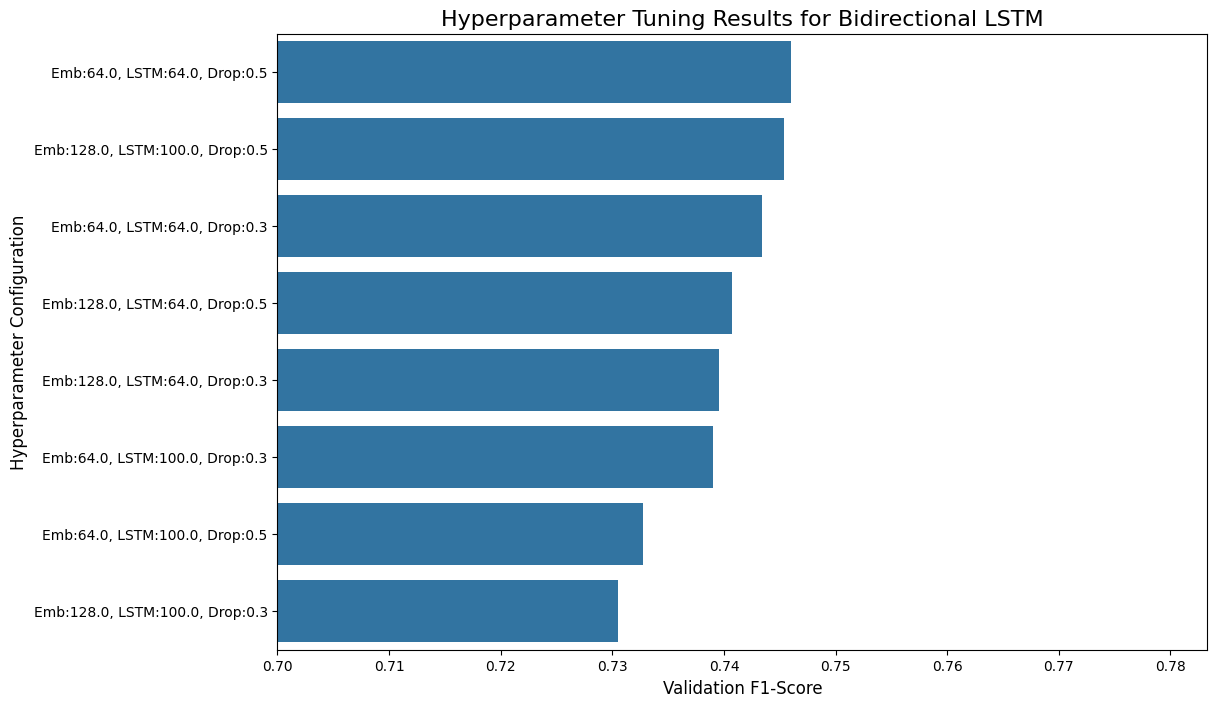

In [74]:
tuning_results_data = {
    'Embedding Dim': [64, 128, 64, 128, 128, 64, 64, 128],
    'LSTM Units': [64, 100, 64, 64, 64, 100, 100, 100],
    'Dropout Rate': [0.5, 0.5, 0.3, 0.5, 0.3, 0.3, 0.5, 0.3],
    'Validation F1-Score': [0.746006, 0.745399, 0.743376, 0.740682, 0.739599, 0.738994, 0.732778, 0.730519]
}
tuning_df = pd.DataFrame(tuning_results_data).sort_values(by='Validation F1-Score', ascending=False).reset_index(drop=True)

# table
print("\n Table 2: Hyperparameter Tuning Results")
display(tuning_df.style.format({'Validation F1-Score': '{:.4f}'}).background_gradient(cmap='viridis', subset=['Validation F1-Score']))

# Create a more readable label for each bar
tuning_df['config_label'] = tuning_df.apply(lambda row: f"Emb:{row['Embedding Dim']}, LSTM:{row['LSTM Units']}, Drop:{row['Dropout Rate']}", axis=1)

plt.figure(figsize=(12, 8))
sns.barplot(x='Validation F1-Score', y='config_label', data=tuning_df, legend=False)

plt.title('Hyperparameter Tuning Results for Bidirectional LSTM', fontsize=16)
plt.xlabel('Validation F1-Score', fontsize=12)
plt.ylabel('Hyperparameter Configuration', fontsize=12)
plt.xlim(left=0.7) # Start x-axis at 0.7 to better show differences
plt.show()

## Final Model Training

Finally, I trained my best performing model with full 5 epochs (took quite a while!). Epochs didn't add much value and I ended up with the final F1 score of 0.74 and the model ability to correctly predict 73% of disasters from tweets.

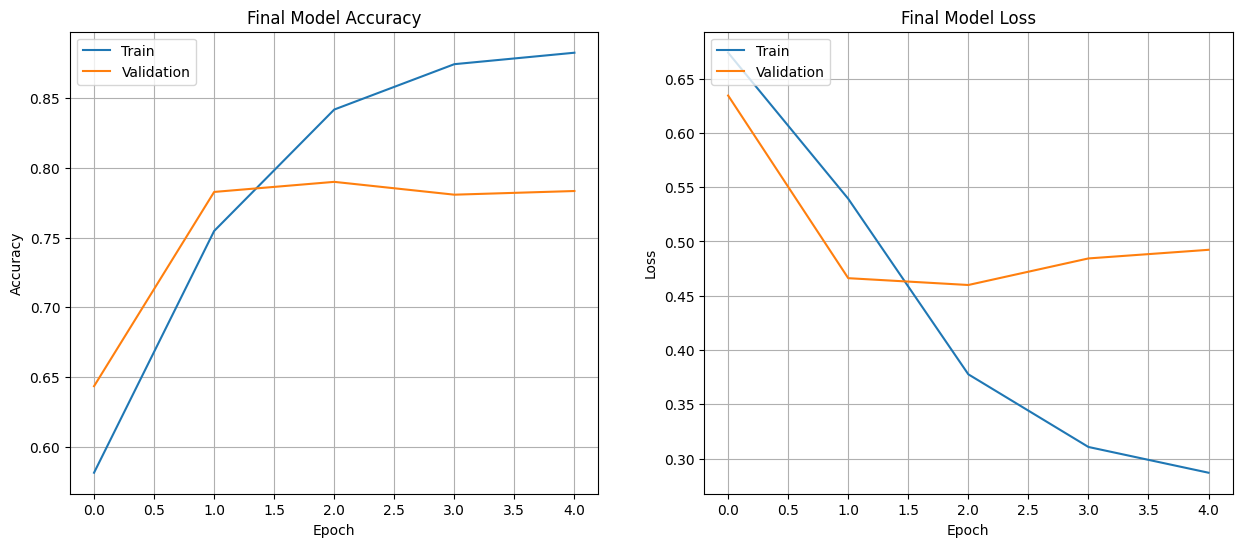


 Final Model Performance
Evaluating Final Tuned Model
48/48 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step
Validation F1-Score: 0.7410

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.82      0.81       874
           1       0.76      0.73      0.74       649

    accuracy                           0.78      1523
   macro avg       0.78      0.78      0.78      1523
weighted avg       0.78      0.78      0.78      1523



0.7409733124018838

In [66]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Traiining and test accuracy values
ax1.plot(history_final.history['accuracy'])
ax1.plot(history_final.history['val_accuracy'])
ax1.set_title('Final Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Validation'], loc='upper left')
ax1.grid(True)

# Training and test loss values
ax2.plot(history_final.history['loss'])
ax2.plot(history_final.history['val_loss'])
ax2.set_title('Final Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'], loc='upper left')
ax2.grid(True)

plt.show()


# Final report
print("\n Final Model Performance")

evaluate_model(final_model, X_val, y_val, "Final Tuned Model")

# Conclusions

In this project I navigated the difficult process of building and optimizing a deep learning model to classify disaster-related tweets. By comparing different Recurrent Neural Network models and fine-tuning the best performer, I developed a well-performing classifier that effectively distinguishes between real disasters and unrelated chatter. This whole exercise taught me about the need to precisely plan computation resources necessary and avilable training time. Getting through the entire exercise was extremely time consuming (over 48 hours of pure training time!)

## Summary of Findings
The key finding was that model architecture and tuning are both critical for success. Our initial experiments demonstrated that gated architectures like LSTMs and GRUs are ideal for this task, as they outperformed a baseline Simple RNN. While the Bidirectional LSTM did not show an immediate advantage, hyperparameter tuning proved to be the right step. The optimization process revealed that a simpler model with strong regularization (Embedding Dim=64, LSTM Units=64, Dropout=0.5) achieved the best F1-score of 0.746, preventing overfitting and improving the model's ability to generalize.

## Learnings and Takeaways
This project provided several key takeaways. It reinforced the importance of choosing the right evaluation metric; focusing on the F1-score was crucial for accurately assessing performance on this imbalanced dataset. Also, it highlighted the trade-off between model complexity and performance. The winning configuration was not the largest or most complex, but the one that was best regularized for the size of the dataset. Finally, the entire process underscores that building a successful machine learning model is an iterative cycle of comparison, analysis, and optimization.

## Future Work
While this final model is effective, there are lots of things to improve. Likely the best next step would be to leverage pre-trained word embeddings like GloVe or Word2Vec. These embeddings are trained on massive texts data sets and would provide the model with a much richer understanding of language. Additionally, exploring state-of-the-art Transformer architectures like BERT would almost certainly lead me to another significant boost in performance.

# Submission generation

In [76]:
test_df = pd.read_csv('test.csv')
test_df['cleaned_text'] = test_df['text'].apply(clean_text)
test_sequences = tokenizer.texts_to_sequences(test_df['cleaned_text'])
X_test = pad_sequences(test_sequences, maxlen=MAX_LEN)
predictions_probs = final_model.predict(X_test)
predictions = (predictions_probs > 0.5).astype(int).flatten()

submission_df = pd.DataFrame({
    'id': test_df['id'],
    'target': predictions
})

submission_df.to_csv('submission.csv', index=False)

print("Submission file 'submission.csv' created successfully!")
print("Here's a preview:")
print(submission_df.head())

102/102 ━━━━━━━━━━━━━━━━━━━━ 169s 2s/step
Submission file 'submission.csv' created successfully!
Here's a preview:
   id  target
0   0       1
1   2       1
2   3       1
3   9       1
4  11       1


In [77]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.
